In [1]:
# Import required libraries
%pip install optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna
import random

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set constant seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Downgrade numpy for TensorFlow compatibility (run this cell and restart kernel)
%pip install numpy==1.26.4


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load dataset and select top 14 features
features = [
    'RiskScore', 'MonthlyCharges', 'AvgChargesPerMonth', 'ContractRisk', 'Contract',
    'TotalServices', 'TotalCharges', 'EstimatedCLV', 'HasFamily', 'tenure',
    'Partner', 'HighValueCustomer', 'PaymentRisk', 'Dependents'
]
df = pd.read_csv('final_telco_engineered.csv')
X = df[features]
# Assuming target column is 'Churn' (update if different)
y = df['Churn']

In [4]:
# Identify categorical and numerical columns for preprocessing
categorical_cols = ['Contract', 'HasFamily', 'Partner', 'HighValueCustomer', 'Dependents']
numerical_cols = [col for col in features if col not in categorical_cols]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [5]:
# Train/validation/test split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=SEED, stratify=y_temp)
# 0.1111 * 0.90 ≈ 0.10

In [6]:
# Ensure target variable is numeric (0/1)
if y_train.dtype == 'O' or y_train.dtype.name == 'category':
    y_train = y_train.map({'No': 0, 'Yes': 1}).astype(int)
    y_val = y_val.map({'No': 0, 'Yes': 1}).astype(int)
    y_test = y_test.map({'No': 0, 'Yes': 1}).astype(int)

In [7]:
# Fit preprocessor on ORIGINAL training data (before oversampling)
# This ensures scaling parameters reflect true feature distribution
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Now apply random oversampling to balance classes 50/50 on PREPROCESSED training data
from sklearn.utils import resample

# Show class distribution before oversampling
print("Before oversampling:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))

# Combine preprocessed X_train and y_train for resampling
_df_train = pd.DataFrame(X_train_proc)
_df_train['Churn'] = y_train.reset_index(drop=True)
_df_majority = _df_train[_df_train['Churn'] == 0]
_df_minority = _df_train[_df_train['Churn'] == 1]

# Upsample minority to match majority count
_df_minority_up = resample(
    _df_minority,
    replace=True,
    n_samples=len(_df_majority),
    random_state=SEED,
)

# Recombine and shuffle
_df_balanced = pd.concat([_df_majority, _df_minority_up], axis=0)
_df_balanced = _df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Split back into features/target
X_train_proc = _df_balanced.drop(columns=['Churn']).values
y_train = _df_balanced['Churn'].astype(int).values

print("\nAfter oversampling:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))


Before oversampling:
Churn
0    4138
1    1495
Name: count, dtype: int64
Churn
0    0.7346
1    0.2654
Name: proportion, dtype: float64

After oversampling:
0    4138
1    4138
Name: count, dtype: int64
0    0.5
1    0.5
Name: proportion, dtype: float64



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2025-11-21 12:24:30,421] A new study created in memory with name: no-name-51471c8c-7171-4664-bd53-4189f02d5636
[I 2025-11-21 12:24:30,421] A new study created in memory with name: no-name-51471c8c-7171-4664-bd53-4189f02d5636
  0%|          | 0/50 [00:00<?, ?it/s]2025-11-21 12:24:30.446622: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-21 12:24:30.446666: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-21 12:24:30.446675: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-21 12:24:30.446697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUM

Early stopping triggered at epoch 21; restoring best weights.
[I 2025-11-21 12:24:59,068] Trial 0 finished with value: 0.15661323070526123 and parameters: {'n_units': 58, 'lr': 0.007969454818643935, 'dropout': 0.36599697090570255, 'batch_size': 90}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:   4%|▍         | 2/50 [01:00<24:29, 30.61s/it]

[I 2025-11-21 12:25:31,054] Trial 1 finished with value: 0.16071683168411255 and parameters: {'n_units': 33, 'lr': 0.00020511104188433984, 'dropout': 0.02904180608409973, 'batch_size': 116}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:   6%|▌         | 3/50 [01:30<23:32, 30.06s/it]

[I 2025-11-21 12:26:00,456] Trial 2 finished with value: 0.15849214792251587 and parameters: {'n_units': 83, 'lr': 0.0026070247583707684, 'dropout': 0.010292247147901223, 'batch_size': 126}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:   8%|▊         | 4/50 [02:13<27:11, 35.47s/it]

Early stopping triggered at epoch 19; restoring best weights.
[I 2025-11-21 12:26:44,222] Trial 3 finished with value: 0.1580895185470581 and parameters: {'n_units': 110, 'lr': 0.00026587543983272726, 'dropout': 0.09091248360355031, 'batch_size': 49}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  10%|█         | 5/50 [02:47<26:02, 34.73s/it]

Early stopping triggered at epoch 17; restoring best weights.
[I 2025-11-21 12:27:17,650] Trial 4 finished with value: 0.15791404247283936 and parameters: {'n_units': 50, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  12%|█▏        | 6/50 [03:38<29:37, 40.40s/it]

[I 2025-11-21 12:28:09,058] Trial 5 finished with value: 0.1580585241317749 and parameters: {'n_units': 85, 'lr': 0.00019010245319870352, 'dropout': 0.14607232426760908, 'batch_size': 67}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  14%|█▍        | 7/50 [04:00<24:39, 34.40s/it]

Early stopping triggered at epoch 14; restoring best weights.
[I 2025-11-21 12:28:31,107] Trial 6 finished with value: 0.15832698345184326 and parameters: {'n_units': 67, 'lr': 0.0037183641805732083, 'dropout': 0.09983689107917987, 'batch_size': 81}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  16%|█▌        | 8/50 [05:10<31:54, 45.58s/it]

[I 2025-11-21 12:29:40,628] Trial 7 finished with value: 0.1603555679321289 and parameters: {'n_units': 82, 'lr': 0.0001238513729886094, 'dropout': 0.3037724259507192, 'batch_size': 48}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  18%|█▊        | 9/50 [05:39<27:34, 40.35s/it]

Early stopping triggered at epoch 25; restoring best weights.
[I 2025-11-21 12:30:09,457] Trial 8 finished with value: 0.15821337699890137 and parameters: {'n_units': 23, 'lr': 0.007902619549708232, 'dropout': 0.4828160165372797, 'batch_size': 110}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  20%|██        | 10/50 [06:26<28:18, 42.45s/it]

[I 2025-11-21 12:30:56,636] Trial 9 finished with value: 0.16021615266799927 and parameters: {'n_units': 50, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  22%|██▏       | 11/50 [06:45<23:04, 35.50s/it]

Early stopping triggered at epoch 14; restoring best weights.
[I 2025-11-21 12:31:16,371] Trial 10 finished with value: 0.15822887420654297 and parameters: {'n_units': 122, 'lr': 0.0008844120332118486, 'dropout': 0.4294172356616489, 'batch_size': 94}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  24%|██▍       | 12/50 [07:08<19:59, 31.58s/it]

Early stopping triggered at epoch 16; restoring best weights.
[I 2025-11-21 12:31:38,975] Trial 11 finished with value: 0.15819787979125977 and parameters: {'n_units': 53, 'lr': 0.0006611895156969731, 'dropout': 0.21137566250973716, 'batch_size': 93}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  26%|██▌       | 13/50 [07:41<19:41, 31.92s/it]

Early stopping triggered at epoch 9; restoring best weights.
[I 2025-11-21 12:32:11,684] Trial 12 finished with value: 0.15849733352661133 and parameters: {'n_units': 48, 'lr': 0.00952900642840654, 'dropout': 0.35919019107087624, 'batch_size': 34}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  28%|██▊       | 14/50 [08:04<17:30, 29.17s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 12:32:34,507] Trial 13 finished with value: 0.1583889126777649 and parameters: {'n_units': 68, 'lr': 0.0032763394147438743, 'dropout': 0.23635700332897427, 'batch_size': 61}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  30%|███       | 15/50 [08:23<15:16, 26.18s/it]

Early stopping triggered at epoch 13; restoring best weights.
[I 2025-11-21 12:32:53,747] Trial 14 finished with value: 0.15835797786712646 and parameters: {'n_units': 34, 'lr': 0.0015253421517969652, 'dropout': 0.2741697615030259, 'batch_size': 89}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  32%|███▏      | 16/50 [09:01<16:54, 29.85s/it]

Early stopping triggered at epoch 18; restoring best weights.
[I 2025-11-21 12:33:32,129] Trial 15 finished with value: 0.15816694498062134 and parameters: {'n_units': 60, 'lr': 0.00044697688838941463, 'dropout': 0.38920169658429116, 'batch_size': 56}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  34%|███▍      | 17/50 [09:21<14:45, 26.83s/it]

Early stopping triggered at epoch 15; restoring best weights.
[I 2025-11-21 12:33:51,944] Trial 16 finished with value: 0.15822887420654297 and parameters: {'n_units': 100, 'lr': 0.0018087695390909585, 'dropout': 0.18776780355845424, 'batch_size': 102}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  36%|███▌      | 18/50 [09:34<12:08, 22.78s/it]

Early stopping triggered at epoch 7; restoring best weights.
[I 2025-11-21 12:34:05,289] Trial 17 finished with value: 0.15914255380630493 and parameters: {'n_units': 38, 'lr': 0.004698762182371354, 'dropout': 0.4996812193207756, 'batch_size': 76}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  38%|███▊      | 19/50 [10:36<17:48, 34.46s/it]

Early stopping triggered at epoch 20; restoring best weights.
[I 2025-11-21 12:35:06,942] Trial 18 finished with value: 0.1592509150505066 and parameters: {'n_units': 18, 'lr': 0.0004047967665695232, 'dropout': 0.3102082402018671, 'batch_size': 37}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  40%|████      | 20/50 [11:00<15:40, 31.36s/it]

Early stopping triggered at epoch 16; restoring best weights.
[I 2025-11-21 12:35:31,075] Trial 19 finished with value: 0.15738236904144287 and parameters: {'n_units': 75, 'lr': 0.005523706053063484, 'dropout': 0.41984459153515774, 'batch_size': 86}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  42%|████▏     | 21/50 [11:28<14:40, 30.37s/it]

Early stopping triggered at epoch 22; restoring best weights.
[I 2025-11-21 12:35:59,138] Trial 20 finished with value: 0.1573616862297058 and parameters: {'n_units': 101, 'lr': 0.006320887898989788, 'dropout': 0.4288093836883619, 'batch_size': 103}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  44%|████▍     | 22/50 [11:51<13:03, 27.97s/it]

Early stopping triggered at epoch 17; restoring best weights.
[I 2025-11-21 12:36:21,531] Trial 21 finished with value: 0.1573101282119751 and parameters: {'n_units': 97, 'lr': 0.005807064832382495, 'dropout': 0.42680160851565435, 'batch_size': 104}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  46%|████▌     | 23/50 [12:09<11:14, 24.99s/it]

Early stopping triggered at epoch 13; restoring best weights.
[I 2025-11-21 12:36:39,576] Trial 22 finished with value: 0.157723069190979 and parameters: {'n_units': 96, 'lr': 0.006481068566439701, 'dropout': 0.43510461665270816, 'batch_size': 105}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 0. Best value: 0.156613:  48%|████▊     | 24/50 [12:29<10:15, 23.68s/it]

Early stopping triggered at epoch 15; restoring best weights.
[I 2025-11-21 12:37:00,174] Trial 23 finished with value: 0.15871411561965942 and parameters: {'n_units': 123, 'lr': 0.0024922721688848126, 'dropout': 0.4624605653897651, 'batch_size': 98}. Best is trial 0 with value: 0.15661323070526123.


Best trial: 24. Best value: 0.1562:  50%|█████     | 25/50 [12:48<09:11, 22.06s/it] 

Early stopping triggered at epoch 15; restoring best weights.
[I 2025-11-21 12:37:18,452] Trial 24 finished with value: 0.15620028972625732 and parameters: {'n_units': 103, 'lr': 0.009484788621244801, 'dropout': 0.3818736974574264, 'batch_size': 118}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  52%|█████▏    | 26/50 [12:58<07:28, 18.69s/it]

Early stopping triggered at epoch 8; restoring best weights.
[I 2025-11-21 12:37:29,282] Trial 25 finished with value: 0.1587037444114685 and parameters: {'n_units': 112, 'lr': 0.009700490574796567, 'dropout': 0.3773998338476592, 'batch_size': 124}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  54%|█████▍    | 27/50 [13:14<06:45, 17.64s/it]

Early stopping triggered at epoch 12; restoring best weights.
[I 2025-11-21 12:37:44,464] Trial 26 finished with value: 0.15891027450561523 and parameters: {'n_units': 89, 'lr': 0.004027155024555339, 'dropout': 0.3329623253001934, 'batch_size': 118}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  56%|█████▌    | 28/50 [13:27<06:02, 16.46s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 12:37:58,185] Trial 27 finished with value: 0.15897727012634277 and parameters: {'n_units': 107, 'lr': 0.00715148174770305, 'dropout': 0.286844733752796, 'batch_size': 112}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  58%|█████▊    | 29/50 [13:40<05:24, 15.46s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 12:38:11,297] Trial 28 finished with value: 0.15976202487945557 and parameters: {'n_units': 92, 'lr': 0.004801865357803107, 'dropout': 0.39389289213772866, 'batch_size': 120}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  60%|██████    | 30/50 [13:58<05:20, 16.05s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 12:38:28,726] Trial 29 finished with value: 0.1585230827331543 and parameters: {'n_units': 76, 'lr': 0.002578878403662749, 'dropout': 0.4601040202796435, 'batch_size': 110}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  62%|██████▏   | 31/50 [14:12<04:52, 15.40s/it]

Early stopping triggered at epoch 9; restoring best weights.
[I 2025-11-21 12:38:42,614] Trial 30 finished with value: 0.15756303071975708 and parameters: {'n_units': 115, 'lr': 0.009731192610026782, 'dropout': 0.40195086181811057, 'batch_size': 117}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  64%|██████▍   | 32/50 [14:30<04:50, 16.13s/it]

Early stopping triggered at epoch 12; restoring best weights.
[I 2025-11-21 12:39:00,449] Trial 31 finished with value: 0.15779531002044678 and parameters: {'n_units': 104, 'lr': 0.006096877013391237, 'dropout': 0.4499506060789016, 'batch_size': 103}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  66%|██████▌   | 33/50 [14:51<05:00, 17.67s/it]

Early stopping triggered at epoch 13; restoring best weights.
[I 2025-11-21 12:39:21,697] Trial 32 finished with value: 0.1572326421737671 and parameters: {'n_units': 128, 'lr': 0.007455174653481013, 'dropout': 0.35169369209845947, 'batch_size': 97}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  68%|██████▊   | 34/50 [15:18<05:29, 20.57s/it]

Early stopping triggered at epoch 17; restoring best weights.
[I 2025-11-21 12:39:49,056] Trial 33 finished with value: 0.15761983394622803 and parameters: {'n_units': 128, 'lr': 0.0032049010566828806, 'dropout': 0.34564070059485147, 'batch_size': 85}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  70%|███████   | 35/50 [15:37<05:02, 20.17s/it]

Early stopping triggered at epoch 12; restoring best weights.
[I 2025-11-21 12:40:08,282] Trial 34 finished with value: 0.15767139196395874 and parameters: {'n_units': 117, 'lr': 0.007950069431103188, 'dropout': 0.36008858928044174, 'batch_size': 94}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  72%|███████▏  | 36/50 [15:52<04:17, 18.43s/it]

Early stopping triggered at epoch 11; restoring best weights.
[I 2025-11-21 12:40:22,640] Trial 35 finished with value: 0.15818238258361816 and parameters: {'n_units': 60, 'lr': 0.001970790192991548, 'dropout': 0.32220031853983516, 'batch_size': 126}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  74%|███████▍  | 37/50 [16:03<03:32, 16.36s/it]

Early stopping triggered at epoch 7; restoring best weights.
[I 2025-11-21 12:40:34,178] Trial 36 finished with value: 0.15884315967559814 and parameters: {'n_units': 128, 'lr': 0.004750164430426394, 'dropout': 0.3777599400313046, 'batch_size': 111}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  76%|███████▌  | 38/50 [16:24<03:32, 17.74s/it]

Early stopping triggered at epoch 14; restoring best weights.
[I 2025-11-21 12:40:55,148] Trial 37 finished with value: 0.15739786624908447 and parameters: {'n_units': 81, 'lr': 0.00798776446713112, 'dropout': 0.28595955957288605, 'batch_size': 98}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  78%|███████▊  | 39/50 [16:51<03:46, 20.55s/it]

Early stopping triggered at epoch 15; restoring best weights.
[I 2025-11-21 12:41:22,252] Trial 38 finished with value: 0.15819793939590454 and parameters: {'n_units': 92, 'lr': 0.003940113074938151, 'dropout': 0.2594344348069321, 'batch_size': 80}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  80%|████████  | 40/50 [17:17<03:39, 21.96s/it]

Early stopping triggered at epoch 12; restoring best weights.
[I 2025-11-21 12:41:47,491] Trial 39 finished with value: 0.1573411226272583 and parameters: {'n_units': 118, 'lr': 0.006011374975695767, 'dropout': 0.08217182626308461, 'batch_size': 70}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  82%|████████▏ | 41/50 [17:35<03:07, 20.88s/it]

Early stopping triggered at epoch 11; restoring best weights.
[I 2025-11-21 12:42:05,844] Trial 40 finished with value: 0.15894126892089844 and parameters: {'n_units': 106, 'lr': 0.003160877664412753, 'dropout': 0.4124950173056154, 'batch_size': 90}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  84%|████████▍ | 42/50 [18:14<03:30, 26.27s/it]

Early stopping triggered at epoch 22; restoring best weights.
[I 2025-11-21 12:42:44,708] Trial 41 finished with value: 0.1583372950553894 and parameters: {'n_units': 119, 'lr': 0.005441253606737158, 'dropout': 0.05140119764797868, 'batch_size': 72}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  86%|████████▌ | 43/50 [18:44<03:13, 27.59s/it]

Early stopping triggered at epoch 15; restoring best weights.
[I 2025-11-21 12:43:15,362] Trial 42 finished with value: 0.15894639492034912 and parameters: {'n_units': 111, 'lr': 0.007913093311786457, 'dropout': 0.02062848205741874, 'batch_size': 67}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  88%|████████▊ | 44/50 [19:02<02:28, 24.73s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 12:43:33,429] Trial 43 finished with value: 0.15857470035552979 and parameters: {'n_units': 120, 'lr': 0.009898217767648763, 'dropout': 0.1601394987907851, 'batch_size': 82}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  90%|█████████ | 45/50 [19:18<01:49, 21.82s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 12:43:48,471] Trial 44 finished with value: 0.1589980125427246 and parameters: {'n_units': 124, 'lr': 0.005384625960567763, 'dropout': 0.054158449022196735, 'batch_size': 108}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  92%|█████████▏| 46/50 [19:34<01:20, 20.09s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 12:44:04,527] Trial 45 finished with value: 0.15778499841690063 and parameters: {'n_units': 43, 'lr': 0.00742061090152184, 'dropout': 0.08733666380782656, 'batch_size': 97}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  94%|█████████▍| 47/50 [20:27<01:30, 30.18s/it]

[I 2025-11-21 12:44:58,245] Trial 46 finished with value: 0.15996325016021729 and parameters: {'n_units': 113, 'lr': 0.00010012078005753865, 'dropout': 0.11314909635960232, 'batch_size': 68}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  96%|█████████▌| 48/50 [20:49<00:55, 27.71s/it]

Early stopping triggered at epoch 17; restoring best weights.
[I 2025-11-21 12:45:20,185] Trial 47 finished with value: 0.15827536582946777 and parameters: {'n_units': 64, 'lr': 0.0012027872127535497, 'dropout': 0.3675765772640773, 'batch_size': 114}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562:  98%|█████████▊| 49/50 [21:10<00:25, 25.74s/it]

Early stopping triggered at epoch 13; restoring best weights.
[I 2025-11-21 12:45:41,320] Trial 48 finished with value: 0.15840435028076172 and parameters: {'n_units': 98, 'lr': 0.0035214311610746213, 'dropout': 0.2314003455938497, 'batch_size': 90}. Best is trial 24 with value: 0.15620028972625732.


Best trial: 24. Best value: 0.1562: 100%|██████████| 50/50 [21:37<00:00, 25.94s/it]

Early stopping triggered at epoch 9; restoring best weights.
[I 2025-11-21 12:46:07,609] Trial 49 finished with value: 0.15809983015060425 and parameters: {'n_units': 109, 'lr': 0.004149266444076313, 'dropout': 0.4781247810627578, 'batch_size': 50}. Best is trial 24 with value: 0.15620028972625732.


Early stopping triggered at epoch 15; restoring best weights.
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
FNN Test Results:
Accuracy: 0.7262
F1 Score: 0.6101
Precision: 0.4903
Recall (Sensitivity): 0.8075
Specificity: 0.6969
AUC: 0.8406
FNN Test Results:
Accuracy: 0.7262
F1 Score: 0.6101
Precision: 0.4903
Recall (Sensitivity): 0.8075
Specificity: 0.6969
AUC: 0.8406


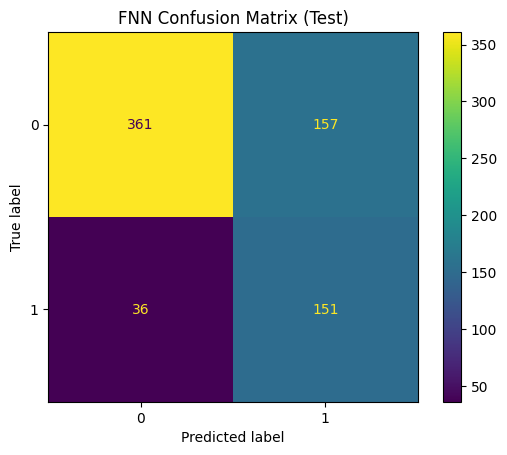

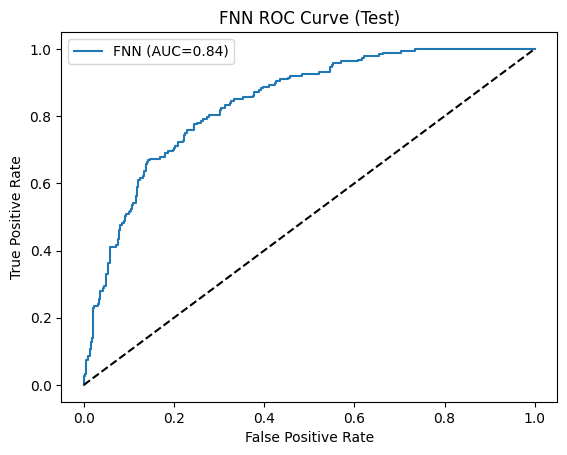

In [8]:
# Feed Forward Neural Network (FNN) with Optuna hyperparameter tuning
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Set TensorFlow seeds for reproducibility
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# Note: Class weights removed in favor of random oversampling on training data above

def create_fnn_model(trial):
    n_units = trial.suggest_int('n_units', 16, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential([
        layers.Input(shape=(X_train_proc.shape[1],)),
        layers.Dense(n_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy', metrics.AUC(name='auc')])
    return model

class VerboseEarlyStopping(EarlyStopping):
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Early stopping triggered at epoch {self.stopped_epoch + 1}; restoring best weights.")

def objective_fnn(trial):
    # Set seeds for each trial
    tf.random.set_seed(SEED)
    tf.keras.utils.set_random_seed(SEED)
    model = create_fnn_model(trial)
    early_stop = VerboseEarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
    history = model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[early_stop]
    )
    val_auc = max(history.history.get('val_auc', [0]))
    return 1 - val_auc  # Optuna minimizes

study_fnn = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_fnn.optimize(objective_fnn, n_trials=50, show_progress_bar=True)

# Train best FNN model
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

best_params_fnn = study_fnn.best_params
best_fnn = create_fnn_model(optuna.trial.FixedTrial(best_params_fnn))
early_stop_final = VerboseEarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
best_fnn.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_fnn['batch_size'],
    verbose=0,
    callbacks=[early_stop_final]
)
# Evaluate on test set
pred_test_fnn = best_fnn.predict(X_test_proc).ravel()
pred_test_label_fnn = (pred_test_fnn > 0.5).astype(int)
cm_fnn = confusion_matrix(y_test, pred_test_label_fnn)
roc_auc_fnn = roc_auc_score(y_test, pred_test_fnn)
f1_fnn = f1_score(y_test, pred_test_label_fnn)
precision_fnn = precision_score(y_test, pred_test_label_fnn)
recall_fnn = recall_score(y_test, pred_test_label_fnn)
specificity_fnn = cm_fnn[0,0] / (cm_fnn[0,0] + cm_fnn[0,1]) if (cm_fnn[0,0] + cm_fnn[0,1]) > 0 else 0
accuracy_fnn = (cm_fnn[0,0] + cm_fnn[1,1]) / cm_fnn.sum()

print('FNN Test Results:')
print(f'Accuracy: {accuracy_fnn:.4f}')
print(f'F1 Score: {f1_fnn:.4f}')
print(f'Precision: {precision_fnn:.4f}')
print(f'Recall (Sensitivity): {recall_fnn:.4f}')
print(f'Specificity: {specificity_fnn:.4f}')
print(f'AUC: {roc_auc_fnn:.4f}')

# Plot Confusion Matrix (Test)
ConfusionMatrixDisplay(cm_fnn).plot()
plt.title('FNN Confusion Matrix (Test)')
plt.show()

# Plot ROC Curve (Test)
fpr_fnn, tpr_fnn, _ = roc_curve(y_test, pred_test_fnn)
plt.figure()
plt.plot(fpr_fnn, tpr_fnn, label=f'FNN (AUC={roc_auc_fnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FNN ROC Curve (Test)')
plt.legend()
plt.show()

[I 2025-11-21 12:48:55,849] A new study created in memory with name: no-name-faf0f2f6-192e-445e-9e58-e31b8bb75889
Best trial: 0. Best value: 0.155942:   2%|▏         | 1/50 [00:41<33:43, 41.30s/it]

Early stopping triggered at epoch 12; restoring best weights.
[I 2025-11-21 12:49:37,147] Trial 0 finished with value: 0.15594220161437988 and parameters: {'n_layers': 3, 'n_units': 124, 'lr': 0.0029106359131330704, 'dropout': 0.2993292420985183, 'batch_size': 47}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:   4%|▍         | 2/50 [01:04<24:17, 30.36s/it]

Early stopping triggered at epoch 15; restoring best weights.
[I 2025-11-21 12:49:59,859] Trial 1 finished with value: 0.1587657332420349 and parameters: {'n_layers': 2, 'n_units': 37, 'lr': 0.005399484409787433, 'dropout': 0.3005575058716044, 'batch_size': 100}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:   6%|▌         | 3/50 [01:22<19:42, 25.15s/it]

Early stopping triggered at epoch 6; restoring best weights.
[I 2025-11-21 12:50:18,804] Trial 2 finished with value: 0.1596432328224182 and parameters: {'n_layers': 2, 'n_units': 126, 'lr': 0.004622589001020831, 'dropout': 0.10616955533913808, 'batch_size': 49}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:   8%|▊         | 4/50 [01:54<21:04, 27.50s/it]

Early stopping triggered at epoch 13; restoring best weights.
[I 2025-11-21 12:50:49,900] Trial 3 finished with value: 0.1591322422027588 and parameters: {'n_layers': 2, 'n_units': 61, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  10%|█         | 5/50 [02:35<24:29, 32.66s/it]

Early stopping triggered at epoch 19; restoring best weights.
[I 2025-11-21 12:51:31,719] Trial 4 finished with value: 0.1608356237411499 and parameters: {'n_layers': 3, 'n_units': 45, 'lr': 0.0003839629299804173, 'dropout': 0.18318092164684585, 'batch_size': 76}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  12%|█▏        | 6/50 [04:08<38:52, 53.02s/it]

Early stopping triggered at epoch 19; restoring best weights.
[I 2025-11-21 12:53:04,256] Trial 5 finished with value: 0.15959161520004272 and parameters: {'n_layers': 4, 'n_units': 51, 'lr': 0.0010677482709481358, 'dropout': 0.29620728443102123, 'batch_size': 36}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  14%|█▍        | 7/50 [04:49<35:17, 49.24s/it]

[I 2025-11-21 12:53:45,708] Trial 6 finished with value: 0.16440749168395996 and parameters: {'n_layers': 3, 'n_units': 48, 'lr': 0.00013492834268013249, 'dropout': 0.4744427686266666, 'batch_size': 125}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  16%|█▌        | 8/50 [06:03<39:54, 57.00s/it]

Early stopping triggered at epoch 30; restoring best weights.
[I 2025-11-21 12:54:59,330] Trial 7 finished with value: 0.1651095151901245 and parameters: {'n_layers': 4, 'n_units': 61, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  18%|█▊        | 9/50 [07:15<42:12, 61.78s/it]

[I 2025-11-21 12:56:11,605] Trial 8 finished with value: 0.15990132093429565 and parameters: {'n_layers': 2, 'n_units': 80, 'lr': 0.00011715937392307068, 'dropout': 0.45466020103939103, 'batch_size': 57}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  20%|██        | 10/50 [08:14<40:34, 60.85s/it]

Early stopping triggered at epoch 18; restoring best weights.
[I 2025-11-21 12:57:10,391] Trial 9 finished with value: 0.15920448303222656 and parameters: {'n_layers': 3, 'n_units': 62, 'lr': 0.001096821720752952, 'dropout': 0.2733551396716398, 'batch_size': 49}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  22%|██▏       | 11/50 [08:59<36:26, 56.07s/it]

Early stopping triggered at epoch 8; restoring best weights.
[I 2025-11-21 12:57:55,611] Trial 10 finished with value: 0.23992419242858887 and parameters: {'n_layers': 4, 'n_units': 122, 'lr': 0.0024673775376624486, 'dropout': 0.0089809378074098, 'batch_size': 33}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  24%|██▍       | 12/50 [09:13<27:24, 43.28s/it]

Early stopping triggered at epoch 8; restoring best weights.
[I 2025-11-21 12:58:09,637] Trial 11 finished with value: 0.15909093618392944 and parameters: {'n_layers': 2, 'n_units': 111, 'lr': 0.008752516219500352, 'dropout': 0.37300873825092634, 'batch_size': 103}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  26%|██▌       | 13/50 [09:33<22:13, 36.04s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 12:58:29,028] Trial 12 finished with value: 0.1580740213394165 and parameters: {'n_layers': 3, 'n_units': 99, 'lr': 0.0032623487002710204, 'dropout': 0.3837864985996777, 'batch_size': 101}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  28%|██▊       | 14/50 [10:06<21:05, 35.16s/it]

Early stopping triggered at epoch 18; restoring best weights.
[I 2025-11-21 12:59:02,166] Trial 13 finished with value: 0.15867280960083008 and parameters: {'n_layers': 3, 'n_units': 101, 'lr': 0.0025842173734186335, 'dropout': 0.39970975947305903, 'batch_size': 97}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  30%|███       | 15/50 [10:20<16:47, 28.80s/it]

Early stopping triggered at epoch 7; restoring best weights.
[I 2025-11-21 12:59:16,199] Trial 14 finished with value: 0.15969997644424438 and parameters: {'n_layers': 3, 'n_units': 96, 'lr': 0.0024519289561700766, 'dropout': 0.4142285278010828, 'batch_size': 115}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  32%|███▏      | 16/50 [10:44<15:30, 27.38s/it]

Early stopping triggered at epoch 11; restoring best weights.
[I 2025-11-21 12:59:40,276] Trial 15 finished with value: 0.16010260581970215 and parameters: {'n_layers': 3, 'n_units': 87, 'lr': 0.00048484014956722736, 'dropout': 0.12747450959997145, 'batch_size': 87}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  34%|███▍      | 17/50 [11:12<15:11, 27.61s/it]

Early stopping triggered at epoch 15; restoring best weights.
[I 2025-11-21 13:00:08,436] Trial 16 finished with value: 0.15650486946105957 and parameters: {'n_layers': 4, 'n_units': 113, 'lr': 0.004261548525190925, 'dropout': 0.3404059366502806, 'batch_size': 113}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  36%|███▌      | 18/50 [11:34<13:44, 25.78s/it]

Early stopping triggered at epoch 12; restoring best weights.
[I 2025-11-21 13:00:29,956] Trial 17 finished with value: 0.15616416931152344 and parameters: {'n_layers': 4, 'n_units': 116, 'lr': 0.008524636948952195, 'dropout': 0.23105737920056402, 'batch_size': 128}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  38%|███▊      | 19/50 [11:59<13:12, 25.55s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 13:00:54,969] Trial 18 finished with value: 0.1874290108680725 and parameters: {'n_layers': 4, 'n_units': 116, 'lr': 0.009162665854514166, 'dropout': 0.19999034969185747, 'batch_size': 86}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  40%|████      | 20/50 [12:24<12:46, 25.56s/it]

Early stopping triggered at epoch 8; restoring best weights.
[I 2025-11-21 13:01:20,551] Trial 19 finished with value: 0.2651808261871338 and parameters: {'n_layers': 4, 'n_units': 128, 'lr': 0.008680399316661742, 'dropout': 0.09672402594611682, 'batch_size': 67}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  42%|████▏     | 21/50 [12:50<12:22, 25.60s/it]

Early stopping triggered at epoch 16; restoring best weights.
[I 2025-11-21 13:01:46,245] Trial 20 finished with value: 0.15931802988052368 and parameters: {'n_layers': 3, 'n_units': 105, 'lr': 0.001682465182463878, 'dropout': 0.24905144901890588, 'batch_size': 122}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  44%|████▍     | 22/50 [13:08<10:52, 23.29s/it]

Early stopping triggered at epoch 8; restoring best weights.
[I 2025-11-21 13:02:04,139] Trial 21 finished with value: 0.16160470247268677 and parameters: {'n_layers': 4, 'n_units': 113, 'lr': 0.005048367675768421, 'dropout': 0.3302996229142289, 'batch_size': 115}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  46%|████▌     | 23/50 [13:43<12:06, 26.91s/it]

Early stopping triggered at epoch 18; restoring best weights.
[I 2025-11-21 13:02:39,507] Trial 22 finished with value: 0.1566184163093567 and parameters: {'n_layers': 4, 'n_units': 117, 'lr': 0.00398018577635178, 'dropout': 0.22772344428040836, 'batch_size': 113}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  48%|████▊     | 24/50 [13:58<10:04, 23.24s/it]

Early stopping triggered at epoch 6; restoring best weights.
[I 2025-11-21 13:02:54,182] Trial 23 finished with value: 0.16796398162841797 and parameters: {'n_layers': 4, 'n_units': 88, 'lr': 0.006247787469743856, 'dropout': 0.16374529382141045, 'batch_size': 126}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  50%|█████     | 25/50 [14:14<08:45, 21.01s/it]

Early stopping triggered at epoch 6; restoring best weights.
[I 2025-11-21 13:03:09,983] Trial 24 finished with value: 0.1612226963043213 and parameters: {'n_layers': 4, 'n_units': 108, 'lr': 0.0014990888212756972, 'dropout': 0.3338962247920462, 'batch_size': 109}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  52%|█████▏    | 26/50 [14:47<09:52, 24.70s/it]

Early stopping triggered at epoch 14; restoring best weights.
[I 2025-11-21 13:03:43,280] Trial 25 finished with value: 0.15871930122375488 and parameters: {'n_layers': 4, 'n_units': 120, 'lr': 0.006379627950967305, 'dropout': 0.27176256684551897, 'batch_size': 92}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  54%|█████▍    | 27/50 [15:14<09:47, 25.52s/it]

Early stopping triggered at epoch 17; restoring best weights.
[I 2025-11-21 13:04:10,731] Trial 26 finished with value: 0.16064977645874023 and parameters: {'n_layers': 3, 'n_units': 90, 'lr': 0.0005740122018683209, 'dropout': 0.4397503979440348, 'batch_size': 128}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  56%|█████▌    | 28/50 [15:55<10:58, 29.94s/it]

Early stopping triggered at epoch 8; restoring best weights.
[I 2025-11-21 13:04:50,988] Trial 27 finished with value: 0.1622602343559265 and parameters: {'n_layers': 4, 'n_units': 128, 'lr': 0.0018418776817629252, 'dropout': 0.4981243863959812, 'batch_size': 42}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  58%|█████▊    | 29/50 [16:12<09:11, 26.26s/it]

Early stopping triggered at epoch 9; restoring best weights.
[I 2025-11-21 13:05:08,664] Trial 28 finished with value: 0.1581566333770752 and parameters: {'n_layers': 3, 'n_units': 106, 'lr': 0.003808073110411095, 'dropout': 0.35710731669051693, 'batch_size': 119}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  60%|██████    | 30/50 [16:31<07:57, 23.89s/it]

Early stopping triggered at epoch 7; restoring best weights.
[I 2025-11-21 13:05:27,033] Trial 29 finished with value: 0.16616249084472656 and parameters: {'n_layers': 4, 'n_units': 74, 'lr': 0.006390484555423465, 'dropout': 0.28906822708359686, 'batch_size': 107}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  62%|██████▏   | 31/50 [16:51<07:11, 22.71s/it]

Early stopping triggered at epoch 6; restoring best weights.
[I 2025-11-21 13:05:46,967] Trial 30 finished with value: 0.1661677360534668 and parameters: {'n_layers': 4, 'n_units': 117, 'lr': 0.003101240238853299, 'dropout': 0.24447682309883734, 'batch_size': 83}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  64%|██████▍   | 32/50 [17:06<06:11, 20.64s/it]

Early stopping triggered at epoch 6; restoring best weights.
[I 2025-11-21 13:06:02,773] Trial 31 finished with value: 0.22138822078704834 and parameters: {'n_layers': 4, 'n_units': 121, 'lr': 0.004346840007180516, 'dropout': 0.21642513778806882, 'batch_size': 112}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  66%|██████▌   | 33/50 [17:22<05:25, 19.17s/it]

Early stopping triggered at epoch 6; restoring best weights.
[I 2025-11-21 13:06:18,507] Trial 32 finished with value: 0.17616605758666992 and parameters: {'n_layers': 4, 'n_units': 113, 'lr': 0.004773435781783638, 'dropout': 0.14839008167593826, 'batch_size': 119}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  68%|██████▊   | 34/50 [17:48<05:37, 21.08s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 13:06:44,060] Trial 33 finished with value: 0.1594780683517456 and parameters: {'n_layers': 4, 'n_units': 122, 'lr': 0.007473577273305822, 'dropout': 0.3180483812144958, 'batch_size': 93}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  70%|███████   | 35/50 [18:13<05:35, 22.35s/it]

Early stopping triggered at epoch 13; restoring best weights.
[I 2025-11-21 13:07:09,359] Trial 34 finished with value: 0.15780043601989746 and parameters: {'n_layers': 3, 'n_units': 94, 'lr': 0.003833539258593755, 'dropout': 0.2505477657909786, 'batch_size': 105}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  72%|███████▏  | 36/50 [18:42<05:40, 24.30s/it]

Early stopping triggered at epoch 12; restoring best weights.
[I 2025-11-21 13:07:38,213] Trial 35 finished with value: 0.15837347507476807 and parameters: {'n_layers': 2, 'n_units': 35, 'lr': 0.00997302684768142, 'dropout': 0.219677058388533, 'batch_size': 68}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  74%|███████▍  | 37/50 [18:57<04:42, 21.70s/it]

Early stopping triggered at epoch 6; restoring best weights.
[I 2025-11-21 13:07:53,844] Trial 36 finished with value: 0.16775751113891602 and parameters: {'n_layers': 4, 'n_units': 103, 'lr': 0.005554937825506715, 'dropout': 0.08224402237649198, 'batch_size': 118}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  76%|███████▌  | 38/50 [19:27<04:47, 23.99s/it]

Early stopping triggered at epoch 8; restoring best weights.
[I 2025-11-21 13:08:23,190] Trial 37 finished with value: 0.15889477729797363 and parameters: {'n_layers': 3, 'n_units': 124, 'lr': 0.0007397820101026395, 'dropout': 0.17563931011015704, 'batch_size': 52}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  78%|███████▊  | 39/50 [19:51<04:25, 24.13s/it]

Early stopping triggered at epoch 12; restoring best weights.
[I 2025-11-21 13:08:47,647] Trial 38 finished with value: 0.1634887456893921 and parameters: {'n_layers': 4, 'n_units': 110, 'lr': 0.00022353557789801714, 'dropout': 0.30177868870004465, 'batch_size': 123}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  80%|████████  | 40/50 [20:20<04:14, 25.43s/it]

Early stopping triggered at epoch 13; restoring best weights.
[I 2025-11-21 13:09:16,122] Trial 39 finished with value: 0.15862637758255005 and parameters: {'n_layers': 2, 'n_units': 116, 'lr': 0.0019612549022229734, 'dropout': 0.23412809409054391, 'batch_size': 75}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  82%|████████▏ | 41/50 [21:44<06:28, 43.17s/it]

Early stopping triggered at epoch 22; restoring best weights.
[I 2025-11-21 13:10:40,690] Trial 40 finished with value: 0.15897738933563232 and parameters: {'n_layers': 3, 'n_units': 73, 'lr': 0.0013842018106753058, 'dropout': 0.26879482854812914, 'batch_size': 43}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  84%|████████▍ | 42/50 [22:07<04:55, 36.88s/it]

Early stopping triggered at epoch 11; restoring best weights.
[I 2025-11-21 13:11:02,892] Trial 41 finished with value: 0.15766620635986328 and parameters: {'n_layers': 3, 'n_units': 95, 'lr': 0.00387609615929528, 'dropout': 0.19636131261436204, 'batch_size': 111}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  86%|████████▌ | 43/50 [22:35<04:01, 34.48s/it]

Early stopping triggered at epoch 15; restoring best weights.
[I 2025-11-21 13:11:31,753] Trial 42 finished with value: 0.1581876277923584 and parameters: {'n_layers': 3, 'n_units': 118, 'lr': 0.0030346340865271843, 'dropout': 0.1936845111648152, 'batch_size': 110}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  88%|████████▊ | 44/50 [23:00<03:08, 31.43s/it]

Early stopping triggered at epoch 11; restoring best weights.
[I 2025-11-21 13:11:56,074] Trial 43 finished with value: 0.15903925895690918 and parameters: {'n_layers': 3, 'n_units': 125, 'lr': 0.0021699088928691284, 'dropout': 0.3090910305775593, 'batch_size': 98}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  90%|█████████ | 45/50 [23:22<02:23, 28.64s/it]

Early stopping triggered at epoch 11; restoring best weights.
[I 2025-11-21 13:12:18,192] Trial 44 finished with value: 0.1574752926826477 and parameters: {'n_layers': 3, 'n_units': 109, 'lr': 0.0041934795527423276, 'dropout': 0.28764198986793116, 'batch_size': 114}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  92%|█████████▏| 46/50 [23:41<01:43, 25.81s/it]

Early stopping triggered at epoch 10; restoring best weights.
[I 2025-11-21 13:12:37,401] Trial 45 finished with value: 0.15838372707366943 and parameters: {'n_layers': 3, 'n_units': 110, 'lr': 0.007378494291173307, 'dropout': 0.2801539512617166, 'batch_size': 128}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  94%|█████████▍| 47/50 [24:03<01:14, 24.70s/it]

Early stopping triggered at epoch 9; restoring best weights.
[I 2025-11-21 13:12:59,517] Trial 46 finished with value: 0.16047942638397217 and parameters: {'n_layers': 4, 'n_units': 101, 'lr': 0.002816227168411903, 'dropout': 0.3705915605657046, 'batch_size': 114}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  96%|█████████▌| 48/50 [24:31<00:51, 25.58s/it]

Early stopping triggered at epoch 12; restoring best weights.
[I 2025-11-21 13:13:27,143] Trial 47 finished with value: 0.15717589855194092 and parameters: {'n_layers': 3, 'n_units': 114, 'lr': 0.00528157212379898, 'dropout': 0.34740969228189367, 'batch_size': 102}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942:  98%|█████████▊| 49/50 [25:00<00:26, 26.63s/it]

Early stopping triggered at epoch 14; restoring best weights.
[I 2025-11-21 13:13:56,232] Trial 48 finished with value: 0.15928709506988525 and parameters: {'n_layers': 3, 'n_units': 41, 'lr': 0.0055331590375383944, 'dropout': 0.3508057132370991, 'batch_size': 104}. Best is trial 0 with value: 0.15594220161437988.


Best trial: 0. Best value: 0.155942: 100%|██████████| 50/50 [25:20<00:00, 30.41s/it]

Early stopping triggered at epoch 6; restoring best weights.
[I 2025-11-21 13:14:16,388] Trial 49 finished with value: 0.1627402901649475 and parameters: {'n_layers': 2, 'n_units': 118, 'lr': 0.00755089962166014, 'dropout': 0.4127957350562472, 'batch_size': 60}. Best is trial 0 with value: 0.15594220161437988.


Early stopping triggered at epoch 12; restoring best weights.
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MLP Test Results:
Accuracy: 0.7645
F1 Score: 0.6327
Precision: 0.5396
Recall (Sensitivity): 0.7647
Specificity: 0.7645
AUC: 0.8366
MLP Test Results:
Accuracy: 0.7645
F1 Score: 0.6327
Precision: 0.5396
Recall (Sensitivity): 0.7647
Specificity: 0.7645
AUC: 0.8366


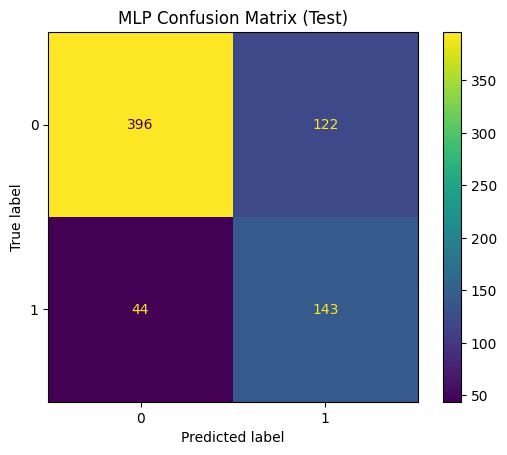

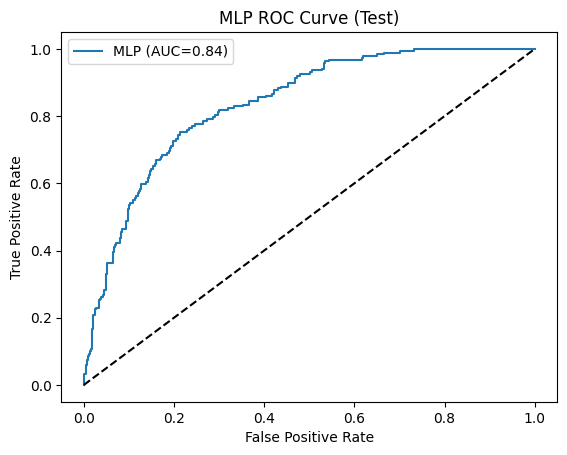

In [9]:
# Multi-Layer Perceptron (MLP) with Optuna hyperparameter tuning
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def create_mlp_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    n_units = trial.suggest_int('n_units', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train_proc.shape[1],)))
    for _ in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy', metrics.AUC(name='auc')])
    return model

class VerboseEarlyStopping(EarlyStopping):
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Early stopping triggered at epoch {self.stopped_epoch + 1}; restoring best weights.")

def objective_mlp(trial):
    tf.random.set_seed(SEED)
    tf.keras.utils.set_random_seed(SEED)
    model = create_mlp_model(trial)
    early_stop = VerboseEarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
    history = model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[early_stop]
    )
    val_auc = max(history.history.get('val_auc', [0]))
    return 1 - val_auc

study_mlp = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_mlp.optimize(objective_mlp, n_trials=50, show_progress_bar=True)

# Train best MLP model
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

best_params_mlp = study_mlp.best_params
best_mlp = create_mlp_model(optuna.trial.FixedTrial(best_params_mlp))
early_stop_final = VerboseEarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
best_mlp.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_mlp['batch_size'],
    verbose=0,
    callbacks=[early_stop_final]
)
# Evaluate on test set
pred_test_mlp = best_mlp.predict(X_test_proc).ravel()
pred_test_label_mlp = (pred_test_mlp > 0.5).astype(int)
cm_mlp = confusion_matrix(y_test, pred_test_label_mlp)
roc_auc_mlp = roc_auc_score(y_test, pred_test_mlp)
f1_mlp = f1_score(y_test, pred_test_label_mlp)
precision_mlp = precision_score(y_test, pred_test_label_mlp)
recall_mlp = recall_score(y_test, pred_test_label_mlp)
specificity_mlp = cm_mlp[0,0] / (cm_mlp[0,0] + cm_mlp[0,1]) if (cm_mlp[0,0] + cm_mlp[0,1]) > 0 else 0
accuracy_mlp = (cm_mlp[0,0] + cm_mlp[1,1]) / cm_mlp.sum()

print('MLP Test Results:')
print(f'Accuracy: {accuracy_mlp:.4f}')
print(f'F1 Score: {f1_mlp:.4f}')
print(f'Precision: {precision_mlp:.4f}')
print(f'Recall (Sensitivity): {recall_mlp:.4f}')
print(f'Specificity: {specificity_mlp:.4f}')
print(f'AUC: {roc_auc_mlp:.4f}')

# Plot Confusion Matrix (Test)
ConfusionMatrixDisplay(cm_mlp).plot()
plt.title('MLP Confusion Matrix (Test)')
plt.show()

# Plot ROC Curve (Test)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, pred_test_mlp)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC={roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve (Test)')
plt.legend()
plt.show()